In [1]:
import pandas as pd
import math
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, 
    precision_recall_curve, confusion_matrix, roc_auc_score, 
    matthews_corrcoef, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

def scores(y_test, y_pred, th=0.5):           
    y_predlabel = [(0. if item < th else 1.) for item in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_predlabel).flatten()
    SPE = tn / (tn + fp)
    MCC = matthews_corrcoef(y_test, y_predlabel)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    sen, spe, pre, f1, mcc, acc, auc, tn, fp, fn, tp = np.array([
        recall_score(y_test, y_predlabel), SPE, precision_score(y_test, y_predlabel), 
        f1_score(y_test, y_predlabel), MCC, accuracy_score(y_test, y_predlabel), 
        roc_auc_score(y_test, y_pred), tn, fp, fn, tp
    ])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aupr = get_aupr(precision, recall)
    return [aupr, auc, f1, acc, sen, spe, pre, fpr, tpr, precision, recall]


In [4]:
# Cleans unused stuff out
def construct_feature_matrices2(lociembeddings_path, rbpembeddings_path, mode='train'):
    """
    Constructs feature matrices for machine learning from ESM-2 embeddings.

    Parameters:
    - lociembeddings_path: Path to loci embeddings CSV
    - rbpembeddings_path: Path to RBP embeddings CSV
    - mode: 'train' or 'test' (default is 'train')

    Returns:
    - If train: features_esm2, labels, groups_loci, groups_phage
    - If test: features_esm2, groups_loci
    """
    RBP_embeddings = pd.read_csv(rbpembeddings_path)
    loci_embeddings = pd.read_csv(lociembeddings_path)

    if mode == 'train':
        interactions = pd.read_csv("./esm-features_ordinal/interaction_matrix.csv", index_col=0).T

        # Get valid phages and loci from interactions
        valid_phages = interactions.columns.tolist()
        valid_loci = interactions.index.tolist()

        # Filter embeddings to only use valid entries
        RBP_embeddings = RBP_embeddings[RBP_embeddings['phage_ID'].str.replace('.fna', '').isin(valid_phages)]
        loci_embeddings = loci_embeddings[loci_embeddings['accession'].isin(valid_loci)]
        print(len(RBP_embeddings), len(loci_embeddings))

    # Construct multi-RBP representations
    multi_embeddings = []
    names = []
    for phage_id in sorted(set(RBP_embeddings['phage_ID'])):
        phage_key = phage_id.split('.')[0]
        if mode == 'test' or phage_key in valid_phages:
            rbp_embeddings = RBP_embeddings.iloc[:, 2:][RBP_embeddings['phage_ID'] == phage_id]
            multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
            names.append(phage_id)
            multi_embeddings.append(multi_embedding)

    multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

    # Build features
    features_lan = []
    labels = []
    groups_loci = []
    groups_phage = []

    for i, accession in enumerate(loci_embeddings['accession']):
        for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
            phage_key = phage_id.split('.')[0]
            if mode == 'train':
                if accession in interactions.index and phage_key in interactions.columns:
                    interaction = interactions.loc[accession][phage_key]
                    if not math.isnan(interaction):
                        features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
                        label = 1 if interaction >= 1 else 0
                        labels.append(label)
                        groups_loci.append(i)
                        groups_phage.append(j)
            elif mode == 'test':
                features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
                groups_loci.append(i)
                groups_phage.append(j)

    features_lan = np.asarray(features_lan)
    print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1] + multiRBP_embeddings.shape[1] - 2))

    if mode == 'train':
        return features_lan, labels, groups_loci, groups_phage
    elif mode == 'test':
        return features_lan, groups_loci
    
    
general_output_path = "./esm-features_ordinal"

loci_embeddings_path = "./esm-features_ordinal/esm2_embeddings_lociJonas.csv"
rbp_embeddings_path ="./esm-features_ordinal/esm2_embeddings_rbpJonas2.csv"

features_esm2, labels, groups_loci, groups_phage = construct_feature_matrices2(loci_embeddings_path, rbp_embeddings_path)


367 402
Dimensions match? True


In [8]:
def construct_feature_matrices(lociembeddings_path, rbpembeddings_path, mode='train'):
    """
    This function constructs two corresponding feature matrices ready for machine learning, 
    starting from the ESM-2 embeddings of RBPs and loci proteins.

    INPUTS:
    - path: general or test path depending on the mode
    - suffix: general or test suffix depending on the mode
    - lociembeddings path to the loci embeddings csv file
    - rbpembeddings path to the rbp embeddings csv file
    - mode: 'train' or 'test', test mode doesn't use an IM (default='train')
    OUTPUT: features_esm2, labels, groups_loci, groups_phage
    """
    RBP_embeddings = pd.read_csv(rbpembeddings_path)
    loci_embeddings = pd.read_csv(lociembeddings_path)
    if mode == 'train':
        interactions = pd.read_csv("./phage_host_interactions"+'.csv', index_col=0)


    # construct multi-RBP representations
    multi_embeddings = []
    names = []
    for phage_id in list(set(RBP_embeddings['phage_ID'])):
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
        names.append(phage_id)
        multi_embeddings.append(multi_embedding)
    multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

    # construct dataframe for training
    features_lan = []
    labels = []
    groups_loci = []
    groups_phage = []

    for i, accession in enumerate(loci_embeddings['accession']):
        for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
            phage_id = phage_id.split('.')[0] # to get rid of the .fna
            if mode == 'train':
                interaction = interactions.loc[accession][phage_id]
                if not math.isnan(interaction): # if the interaction is known
                    # language embeddings
                    features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))

                    # append labels and groups
                    labels.append(int(interaction))
                    groups_loci.append(i)
                    groups_phage.append(j)
            elif mode == 'test':
                # language embeddings
                features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
                
                # append groups
                groups_loci.append(i)
                groups_phage.append(j)

                
    features_lan = np.asarray(features_lan)
    print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

    #np.save(general_path+'/esm2_features'+data_suffix+'.txt', features_lan)
    if mode == 'train':
        return features_lan, labels, groups_loci, groups_phage
    elif mode == 'test':
        return features_lan, groups_loci


In [11]:
general_output_path = "./esm-features"

loci_embeddings_path = "./esm-features/esm2_embeddings_loci.csv"
rbp_embeddings_path ="./esm-features/esm2_embeddings_rbp.csv"

features_esm2, labels, groups_loci, groups_phage = construct_feature_matrices(loci_embeddings_path, rbp_embeddings_path)

Dimensions match? True


In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_all = []
fprs, tprs, precisions, recalls = [], [], [], []

labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)  # ensure it's a NumPy array

pbar = tqdm(total=kf.get_n_splits(features_esm2, labels))

for train_index, test_index in kf.split(features_esm2, labels):
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    imbalance = sum([1 for i in y_train if i == 1]) / sum([1 for i in y_train if i == 0])

    xgb = XGBClassifier(eval_metric='logloss')
    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [ 250],
        'max_depth': [7],
        'learning_rate': [0.3],
        'scale_pos_weight': [1/imbalance]
    }

    # Grid search
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='average_precision', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(Xlan_train, y_train)
    best_model = grid_search.best_estimator_
    score_xgb = best_model.predict_proba(Xlan_test)[:, 1]

    # xgb = XGBClassifier(
    #     scale_pos_weight=1/imbalance,
    #     learning_rate=0.3,
    #     n_estimators=250,
    #     max_depth=7,
    #     n_jobs=-1,
    #     eval_metric='logloss',
    # )
    # xgb.fit(Xlan_train, y_train)
    # score_xgb = xgb.predict_proba(Xlan_test)[:, 1]
    # # Get fold scores
    fold_scores = scores(y_test, score_xgb)
    # 
    # Store metrics
    results_all.append(fold_scores[:7])  # Scalars: AUPR, AUC, F1, ACC, SEN, SPE, PRE
    
    # Store curves for plotting
    fprs.append(fold_scores[7])
    tprs.append(fold_scores[8])
    precisions.append(fold_scores[9])
    recalls.append(fold_scores[10])
    pbar.update(1)

pbar.close()


  0%|          | 0/5 [00:22<?, ?it/s]


Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

 20%|██        | 1/5 [26:20<1:45:20, 1580.04s/it]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

 40%|████      | 2/5 [48:06<1:10:56, 1418.84s/it]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

 60%|██████    | 3/5 [1:12:22<47:51, 1435.91s/it]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

 80%|████████  | 4/5 [1:32:45<22:32, 1352.11s/it]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

100%|██████████| 5/5 [1:49:46<00:00, 1317.24s/it]


In [9]:
metric_names = ["AUPR", "ROC-AUC", "F1", "ACC", "SEN", "SPE", "PRE"]
results_df = pd.DataFrame(results_all, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]

# Print summary
print("=== Fold-wise Performance ===")
display(results_df)
print("\n=== Mean ===")
display(results_df.mean())
print("\n=== Std Dev ===")
display(results_df.std())

=== Fold-wise Performance ===


,AUPR,ROC-AUC,F1,ACC,SEN,SPE,PRE
Fold 1,0.722513,0.880132,0.675478,0.817987,0.749807,0.841034,0.614557
Fold 2,0.750443,0.890481,0.685251,0.825985,0.749807,0.851736,0.630929
Fold 3,0.744942,0.891563,0.684248,0.824815,0.751932,0.849426,0.627742
Fold 4,0.738068,0.885626,0.678358,0.821073,0.747295,0.845993,0.621066
Fold 5,0.722157,0.879559,0.667379,0.817756,0.724111,0.849387,0.618890



=== Mean ===


AUPR       0.735625
ROC-AUC    0.885472
F1         0.678143
ACC        0.821523
SEN        0.744590
SPE        0.847515
PRE        0.622637
dtype: float64


=== Std Dev ===


AUPR       0.012900
ROC-AUC    0.005606
F1         0.007259
ACC        0.003796
SEN        0.011565
SPE        0.004162
PRE        0.006645
dtype: float64

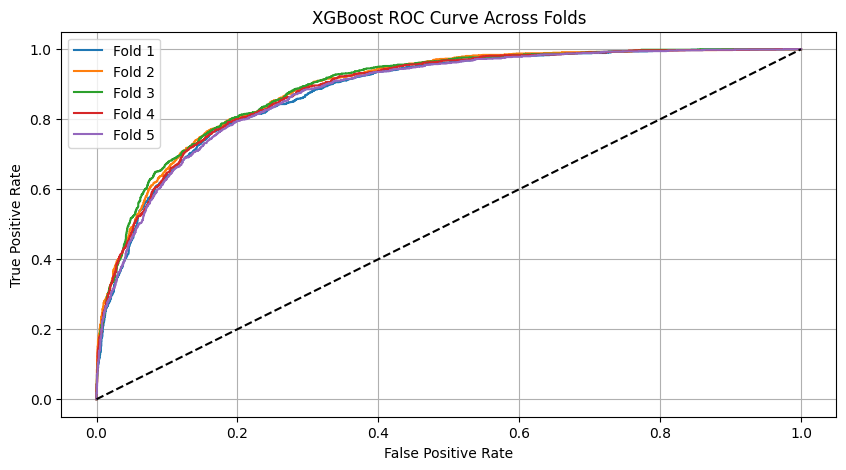

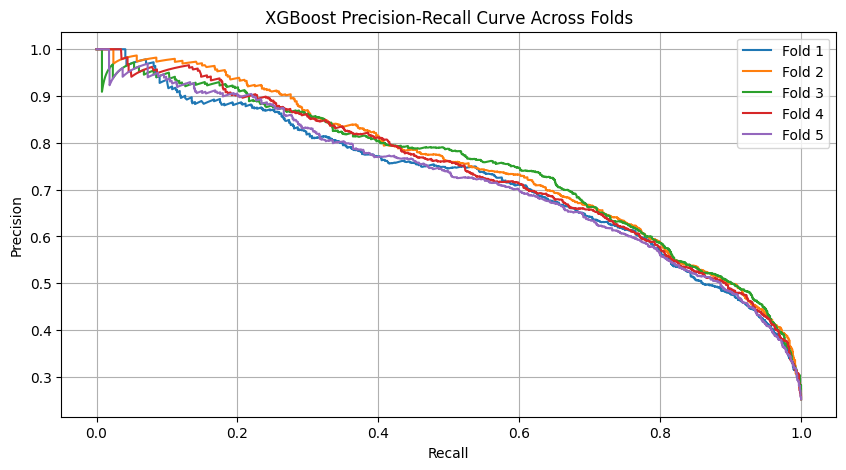

In [10]:
# Plot ROC Curves
plt.figure(figsize=(10, 5))
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Plot PR Curves
plt.figure(figsize=(10, 5))
for i in range(len(precisions)):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.title("XGBoost Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


C:\Users\jonas\AppData\Local\Temp\ipykernel_58516\3057508879.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results_array, labels=metric_names, patch_artist=True,


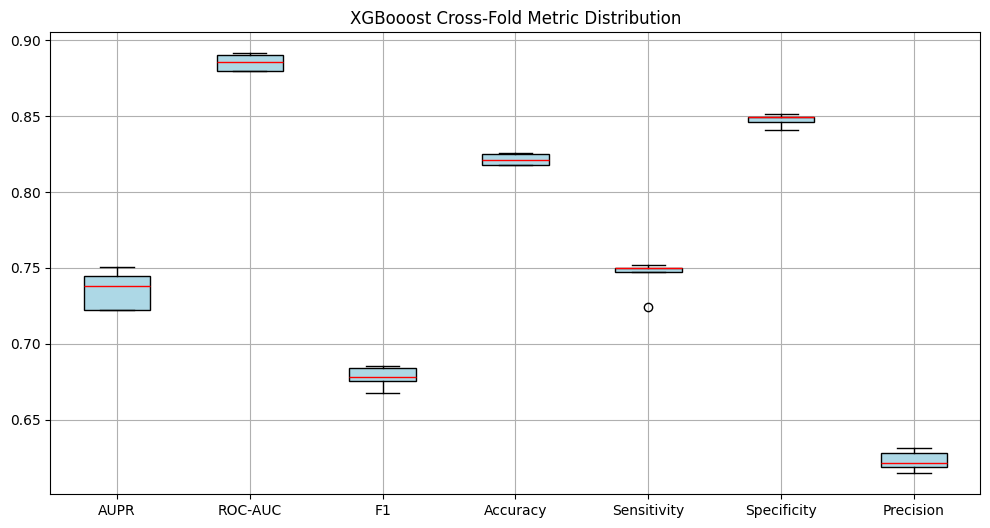

In [11]:

metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
results_array = np.array(results_all)

plt.figure(figsize=(12, 6))
plt.boxplot(results_array, labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("XGBooost Cross-Fold Metric Distribution")
plt.grid()
plt.show()

In [12]:
results_df = pd.DataFrame(results_all, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]
display(results_df)

print("Mean Metrics:")
display(results_df.mean())

,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.722513,0.880132,0.675478,0.817987,0.749807,0.841034,0.614557
Fold 2,0.750443,0.890481,0.685251,0.825985,0.749807,0.851736,0.630929
Fold 3,0.744942,0.891563,0.684248,0.824815,0.751932,0.849426,0.627742
Fold 4,0.738068,0.885626,0.678358,0.821073,0.747295,0.845993,0.621066
Fold 5,0.722157,0.879559,0.667379,0.817756,0.724111,0.849387,0.618890


Mean Metrics:


AUPR           0.735625
ROC-AUC        0.885472
F1             0.678143
Accuracy       0.821523
Sensitivity    0.744590
Specificity    0.847515
Precision      0.622637
dtype: float64

In [13]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cpus = 8

rf_results_all = []
rf_fprs, rf_tprs, rf_precisions, rf_recalls = [], [], [], []

param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)

pbar = tqdm(total=kf.get_n_splits(features_esm2, labels))

for train_index, test_index in kf.split(features_esm2, labels):
    X_train, X_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    rf = RandomForestClassifier(n_jobs=-1, random_state=42)

    grid_search = GridSearchCV(
        rf,
        param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

    # compute all metrics
    metrics = scores(y_test, y_pred_prob)

    rf_results_all.append(metrics[:7])  # Base metrics
    rf_fprs.append(metrics[7])
    rf_tprs.append(metrics[8])
    rf_precisions.append(metrics[9])
    rf_recalls.append(metrics[10])

    print(f"AUPR: {metrics[0]:.4f}, AUC: {metrics[1]:.4f}, "
          f"F1: {metrics[2]:.4f}, Acc: {metrics[3]:.4f}")
    
    pbar.update(1)

pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

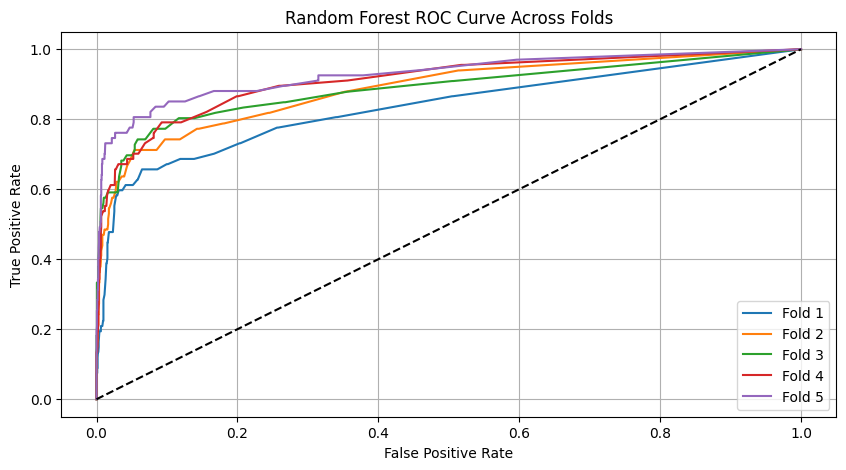

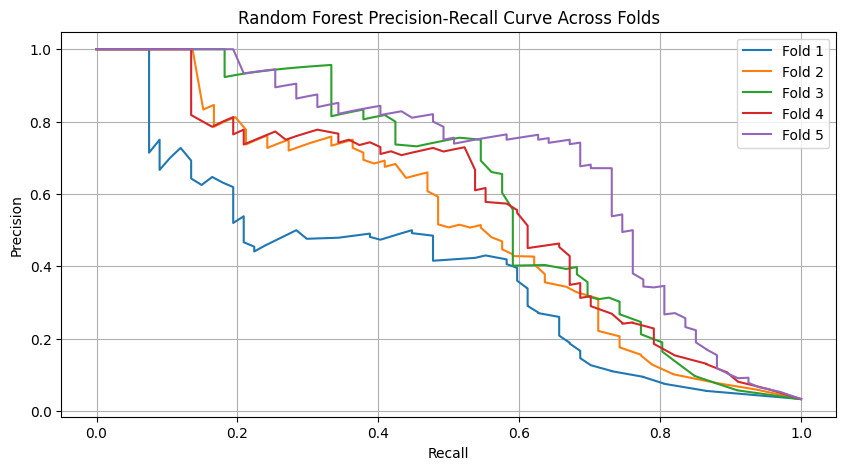

In [20]:
plt.figure(figsize=(10, 5))
for i in range(len(rf_fprs)):
    plt.plot(rf_fprs[i], rf_tprs[i], label=f'Fold {i + 1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(rf_precisions)):
    plt.plot(rf_recalls[i], rf_precisions[i], label=f'Fold {i + 1}')
plt.title("Random Forest Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


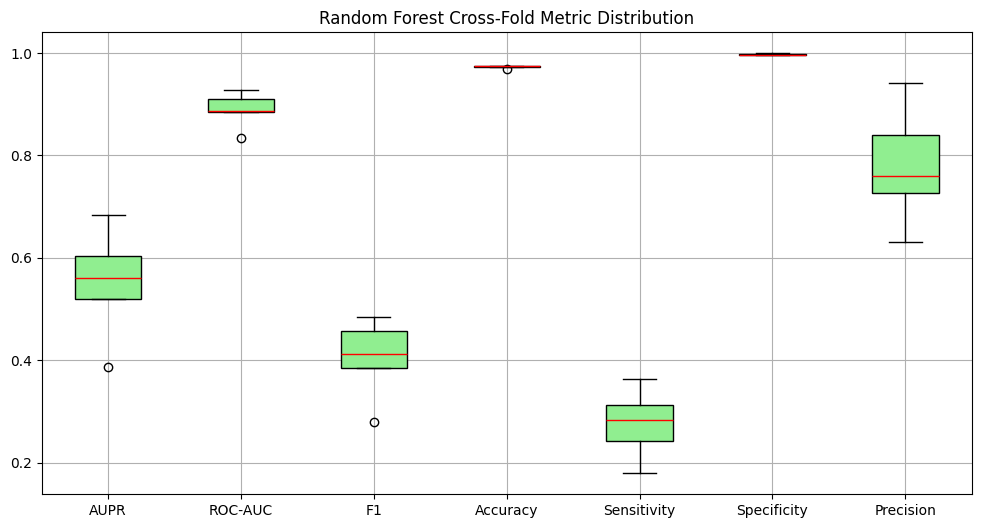

In [21]:
rf_metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
rf_results_array = np.array(rf_results_all)

# Boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rf_results_array, tick_labels=rf_metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Cross-Fold Metric Distribution")
plt.grid()
plt.show()


In [22]:
rf_results_df = pd.DataFrame(rf_results_all, columns=rf_metric_names)
rf_results_df.index = [f"Fold {i + 1}" for i in range(len(rf_results_all))]
display(rf_results_df)

print("Random Forest Mean Metrics:")
display(rf_results_df.mean())

,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.387335,0.833387,0.279070,0.969031,0.179104,0.996382,0.631579
Fold 2,0.518879,0.885678,0.484848,0.974513,0.363636,0.995349,0.727273
Fold 3,0.602947,0.887123,0.385542,0.974513,0.242424,0.999483,0.941176
Fold 4,0.560702,0.910178,0.413043,0.973013,0.283582,0.996898,0.760000
Fold 5,0.683713,0.927789,0.456522,0.975012,0.313433,0.997932,0.840000


Random Forest Mean Metrics:


AUPR           0.550715
ROC-AUC        0.888831
F1             0.403805
Accuracy       0.973216
Sensitivity    0.276436
Specificity    0.997209
Precision      0.780006
dtype: float64

C:\Users\jonas\AppData\Local\Temp\ipykernel_33028\4193799727.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.array(results_all)[:,i] for i in range(7)],


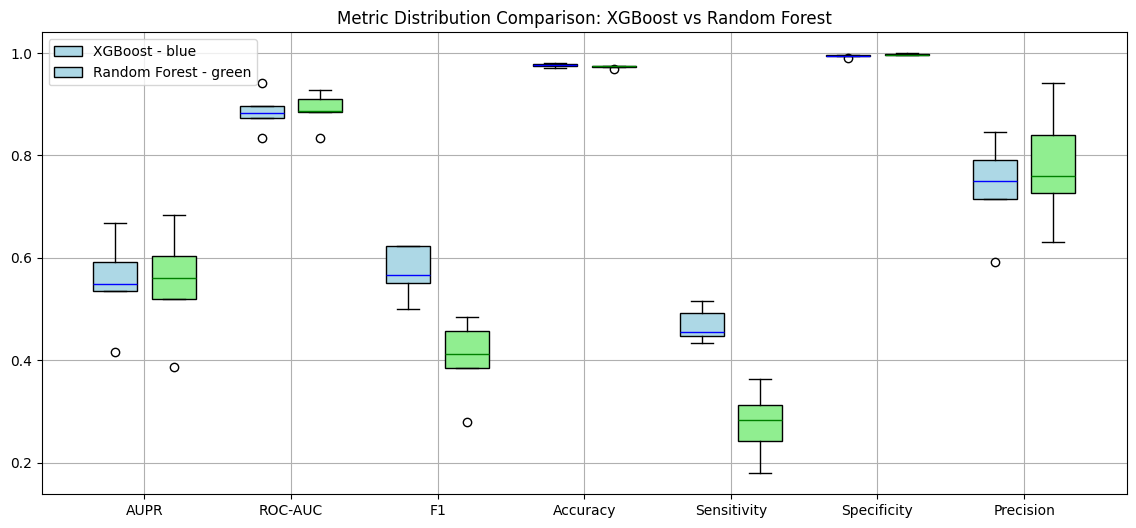

In [24]:

all_metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]

plt.figure(figsize=(14, 6))
plt.boxplot([np.array(results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) - 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'), labels=all_metric_names)

plt.boxplot([np.array(rf_results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) + 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'))

plt.legend(['XGBoost - blue', 'Random Forest - green'])
plt.title("Metric Distribution Comparison: XGBoost vs Random Forest")
plt.grid()
plt.xticks(np.arange(1, 8), all_metric_names)
plt.show()


In [25]:

xgb_mean = pd.DataFrame([np.mean(results_all, axis=0)], columns=all_metric_names, index=["XGBoost"])
rf_mean = pd.DataFrame([np.mean(rf_results_all, axis=0)], columns=all_metric_names, index=["Random Forest"])

display(pd.concat([xgb_mean, rf_mean]))

,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
XGBoost,0.552031,0.885237,0.572598,0.976615,0.468566,0.994108,0.738595
Random Forest,0.550715,0.888831,0.403805,0.973216,0.276436,0.997209,0.780006
